Detect motion with PIL based on the recipe for OpenCV in the reference. This is because installing OpenCV on Raspberry Pi is a bear.

In [18]:
from picamera import PiCamera, array
import numpy as np
from io import BytesIO
from PIL import Image, ImageFilter, ImageMorph, ImageEnhance
import matplotlib.pyplot as plt
import time
import os

Detect motion by imaging in two takes, one after the other, and comparing pixels. Let's write a function to take a snap.

In [19]:
def take_motion_snap(width, height):
    with PiCamera() as Eye:
        time.sleep(1)
        Eye.resolution = (width, height)
        Eye.rotation = 180
        with array.PiRGBArray(camera=Eye) as Stream:
            Eye.exposure_mode = 'auto'
            Eye.awb_mode = 'auto'
            Eye.capture(Stream, format='rgb')
            return Stream.array

In [20]:
def showsnap(imarray, title='', label=''):
    # Show in notebook
    font = {'family': 'serif', 'color': 'red', 'size': 18}
    plt.imshow(imarray)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontdict=font)
    if not label:
        plt.xlabel(" x ".join("{}".format(i) for i in imarray.shape), fontdict=font)
    plt.show()

/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 300x300 to 320x304
  width, height, fwidth, fheight)))


Got an image with width, height as 300, 300.


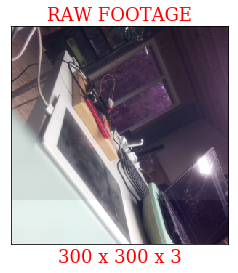

In [21]:
test = take_motion_snap(300, 300)
print("Got an image with width, height as {}, {}.".format(test.shape[0], test.shape[1]))
snap = Image.fromarray(test)
snap.show()
# Show in notebook
showsnap(test, "RAW FOOTAGE")

Now we have an RGB image of the specified height and width as a 3-dimensional numpy array. We want to take the difference between two snaps. Write a wrapper function to use ```take_motion_snap(w, h)```, take two snaps and return the computed difference.

In [22]:
def take_two_motion(intervalsec):
    im_one = take_motion_snap(300, 300)
    tic = time.time()
    toc = tic
    while (toc - tic) < intervalsec:
        toc = time.time()
    im_two = take_motion_snap(300, 300)
    im_diff = np.subtract(im_two, im_one)
    return im_diff


Difference has dimensions (300, 300, 3)
Got a difference of width, height as 300, 300.
The median, mean diff are 2.00, 107.50.


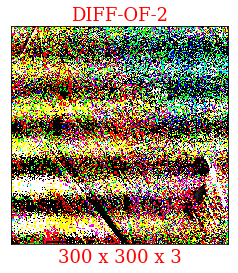

In [23]:
test_diff = take_two_motion(1)
print("Difference has dimensions {}".format(test_diff.shape))
print("Got a difference of width, height as {}, {}.".format(test_diff.shape[0], test_diff.shape[1]))
print("The median, mean diff are {:.2f}, {:.2f}.".format(np.median(test_diff), np.mean(test_diff)))
snap = Image.fromarray(test_diff)
snap.show()
# Show in notebook
showsnap(test_diff, "DIFF-OF-2")

Apply thresholding to remove noise from motion and nuisance effects such as lighting change. In thresholding, we will set the value of a pixel in each of the RGB channels to 0 (min) or 255 (max) accordng to a binary threshold value. In OpenCV, this operation would be ```cv2.threshold(frame_delta, 50, 255, cv2.THRESH_BINARY)```. Use numpy operations here.

In [24]:
def threshold_difference(imdiff, threshold=50):
    return np.uint8(np.where(imdiff > threshold, 255, 0))

Thresholded image has dimensions (300, 300, 3).
Got a thresholded image of width, height as 300, 300.


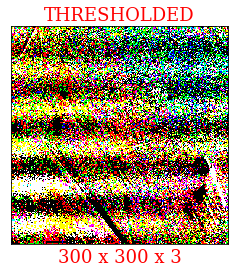

In [25]:
diff_clean = threshold_difference(test_diff, np.mean(test_diff))
print("Thresholded image has dimensions {}.".format(diff_clean.shape))
print("Got a thresholded image of width, height as {}, {}.".format(diff_clean.shape[0], diff_clean.shape[1]))
diff_clean.dtype
snap = Image.fromarray(diff_clean)
snap.show()
# Show in notebook
showsnap(diff_clean, "THRESHOLDED")

Perform erosion and dilation operations to improve signal-to-noise. Apply the PIL methods ```minFilter()``` and ```MaxFilter()```for erosion and dilation respectively. Then, convert the image to black-and-white using the ```convert()``` method. All these methods are of the nature of image filters and operate on image as opposed to numpy array. Mutate accordingly. Get the result as a 2D numpy array.

In [26]:
def erode_dilate(snap, showme=False):
    snap_eroded = snap.filter(ImageFilter.MinFilter(7))
    if showme:
        snap_eroded.show()
        print("After erosion, got median, mean as {:.2f}, {:.2f}.".format(np.median(snap_eroded), np.mean(snap_eroded)))
    snap_dilated = snap_eroded.filter(ImageFilter.MaxFilter(3))
    if showme:
        snap_dilated.show()
        print("After dilation, got median, mean as {:.2f}, {:.2f}.".format(np.median(snap_dilated), np.mean(snap_dilated)))
    snap_bnw = snap_dilated.convert('1')
    bnw_array = np.array(snap_bnw)
    if showme:
        snap_bnw.show()
        print("B&W image for motion detection has dimensions {}".format(bnw_array.shape))
    return bnw_array

After erosion, got median, mean as 0.00, 1.09.
After dilation, got median, mean as 0.00, 2.27.
B&W image for motion detection has dimensions (300, 300)


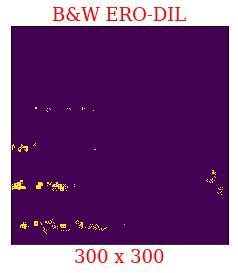

In [27]:
test_bnw = erode_dilate(snap, True)
test_bnw
# Show in notebook
showsnap(test_bnw, "B&W ERO-DIL")

Now that we havd 2D mask with connected regions, let us find the connected components, count them, then rank and sort them. This will give us an idea of whether there is motion in the image. We will use the algorithm in Aaron Becker's [instructional video](https://youtu.be/ticZclUYy88). 

This approach consists of two raster scans of the image. In the first scan, a foreground pixel is assigned a proposed membership label. As some of these labels may refer to the same connected component due to the nature of rastering, synonyms are noted and a second pass is made to update and finalze labels. Further details are explained in code.

In [28]:
test_pass = np.zeros(test_bnw.shape, dtype = np.int32)  # Mask 
count_foreground = 0
first_pass_counter = 0
synonyms = {}

for idx,x in np.ndenumerate(test_bnw):
    aboveme = False     # B&W background
    leftofme = False    # B&W background
    A = 0           # Label none
    B = 0           # Label none
    if x: # Not background
        """
        Is there a pixel above or to the left that is not background?
        Check and if found, obtain the numeric labels 
        marking connected components in 1st pass.
        """
        count_foreground += 1
        if (idx[0] > 0): # Yes, above
            aboveme = test_bnw[idx[0]-1, idx[1]]
            A = test_pass[idx[0]-1, idx[1]] # Get label
        if (idx[1] > 0): # Yes, on left
            leftofme = test_bnw[idx[0], idx[1]-1]
            B = test_pass[idx[0], idx[1]-1] # Get label
        """
        If both left and above have foreground,
        stick the lesser number as the label on our pixel.
        Note the conflict for 2nd pass correction.
        Note that if the lower value has already been marked
        for correction, follow the chain to the lowest value
        in the dictionary of synonymous labels.
        If only one of left or above have foreground,
        stick that label on our pixel.
        Otherwise, mint a new label and stick it on.
        """
        if (aboveme and leftofme): # Contest if not A = B          
            test_pass[idx] = min(A, B) # Resolve
            if (A != B): # Note for update in second pass
                if synonyms.get(min(A, B)):
                    synonyms[max(A, B)] = synonyms.get(min(A, B))
                else:
                    synonyms[max(A, B)] = min(A, B)
        elif aboveme:
            test_pass[idx] = A
        elif leftofme:
            test_pass[idx] = B        
        else:
            first_pass_counter += 1 # New label
            test_pass[idx] = first_pass_counter
            
print("Foreground has {} pixels and procesed {} in 1st pass.".format(sum(sum(test_bnw)), count_foreground))
print("First pass found {} candidates in first pass.".format(first_pass_counter))
Image.fromarray(test_pass).show()
print("Detected {} connected components.".format(len(set(synonyms.values()) )))

Foreground has 894 pixels and procesed 894 in 1st pass.
First pass found 321 candidates in first pass.
Detected 11 connected components.


In [29]:
connected_components = {}
for idx,x in np.ndenumerate(test_pass):
    """
    Execute 2nd raster scan and update labels
    using the synonyms dictionary. 
    """
    if x > 0: # Labeled
        label = synonyms.get(x, 0) 
        if label > 0: # Synonym found for label
            test_pass[idx] = label 
            connected_components[label] = connected_components.get(label, 0) + 1
        else:
            connected_components[x] = connected_components.get(x, 0) + 1
Image.fromarray(test_pass).show()

Found 894 pixels in foreground forming 299 connected regions.
Found 2 connected components above size-threshold of 90.
Mask has dimensions (300, 300).


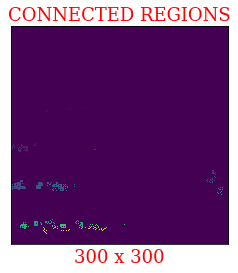

In [30]:
size_threshold = 90
result = {label: connected_components[label] \
        for label in sorted(connected_components, key=connected_components.get, reverse=True) \
        if connected_components[label] > size_threshold}
print("Found {} pixels in foreground forming {} connected regions.".format(sum(connected_components.values()), len(connected_components)))
print("Found {} connected components above size-threshold of {}.".format(len(result), size_threshold))
print("Mask has dimensions {}.".format(test_pass.shape))
showsnap(test_pass, "CONNECTED REGIONS")

It looks like we can call motion detected when the sum of sizes of connected components above a size threshold (say, 90px or 0.1% of image size) is greater than a threshold (say, 4500 or 5% of image size). Let's proceed to write a function to perform the 2-pass detection of connected components.

In [31]:
def find_connected_components(imbnw, showme=False):
    mask = np.zeros(imbnw.shape, dtype = np.int32)  # Mask 
    count_foreground = 0
    first_pass_counter = 0
    synonyms = {}

    for idx, x in np.ndenumerate(imbnw):
        aboveme = False     # B&W background
        leftofme = False    # B&W background
        A = 0           # Label none
        B = 0           # Label none
        if x: # Not background
            """
            Is there a pixel above or to the left that is not background?
            Check and if found, obtain the numeric labels 
            marking connected components in 1st pass.
            """
            count_foreground += 1
            if (idx[0] > 0): # Yes, above
                aboveme = imbnw[idx[0]-1, idx[1]]
                A = mask[idx[0]-1, idx[1]] # Get label
            if (idx[1] > 0): # Yes, on left
                leftofme = imbnw[idx[0], idx[1]-1]
                B = mask[idx[0], idx[1]-1] # Get label
            """
            If both left and above have foreground,
            stick the lesser number as the label on our pixel.
            Note the conflict for 2nd pass correction.
            Note that if the lower value has already been marked
            for correction, follow the chain to the lowest value
            in the dictionary of synonymous labels.
            If only one of left or above have foreground,
            stick that label on our pixel.
            Otherwise, mint a new label and stick it on.
            """
            if (aboveme and leftofme): # Contest if not A = B          
                mask[idx] = min(A, B) # Resolve
                if (A != B): # Note for update in second pass
                    if synonyms.get(min(A, B)):
                        synonyms[max(A, B)] = synonyms.get(min(A, B))
                    else:
                        synonyms[max(A, B)] = min(A, B)
            elif aboveme:
                mask[idx] = A
            elif leftofme:
                mask[idx] = B        
            else:
                first_pass_counter += 1 # New label
                mask[idx] = first_pass_counter

    if showme:
        Image.fromarray(mask).show()

    connected_components = {}
    
    for idx,x in np.ndenumerate(mask):
        """
        Execute 2nd raster scan and update labels
        using the synonyms dictionary. 
        """
        if x > 0: # Labeled
            label = synonyms.get(x, 0) 
            if label > 0: # Synonym found for label
                mask[idx] = label 
                connected_components[label] = connected_components.get(label, 0) + 1
            else:
                connected_components[x] = connected_components.get(x, 0) + 1
    
    if showme:
        Image.fromarray(mask).show()
    
    return (mask, connected_components)

In [32]:
def analyze_connect_components(regions, size_threshold):
    size = 90
    result = {label: regions[label] \
        for label in sorted(regions, key=regions.get, reverse=True) \
        if regions[label] > size_threshold}
    return result

Now, find the connected regions and report results.

Found 299 connected components with {75: 149, 94: 99} above size-threshold of 90.
Foreground has 894 pixels.


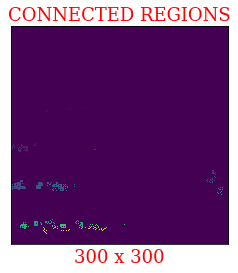

In [33]:
mask, cc = find_connected_components(test_bnw, showme=True)
res = analyze_connect_components(cc, 90)
print("Found {} connected components with {} above size-threshold of 90.".format(len(cc), res if res else 0))
print("Foreground has {} pixels.".format(sum(cc.values())))
showsnap(mask, "CONNECTED REGIONS")

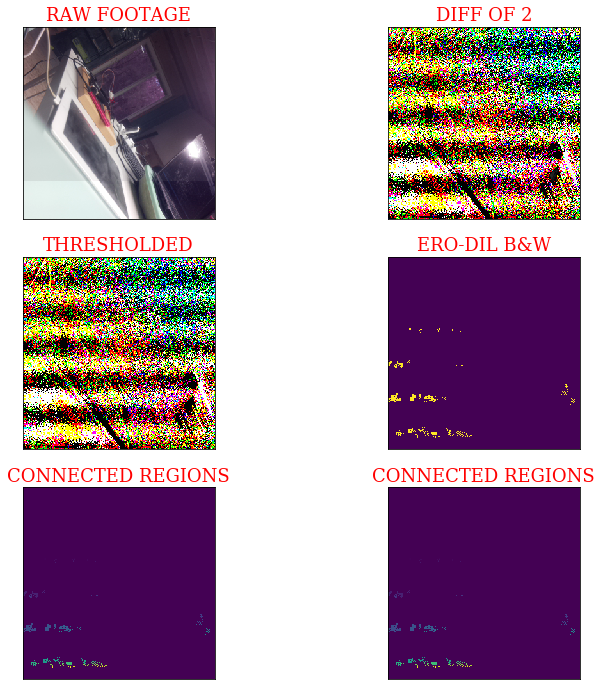

In [34]:
outline = (3, 2)
labels = np.array(["RAW FOOTAGE", "DIFF OF 2", "THRESHOLDED", "ERO-DIL B&W", "CONNECTED REGIONS", "CONNECTED REGIONS"])
labels = labels.reshape(outline)
labels

font = {'family': 'serif', 'color': 'red', 'size': 18}

_, axarray = plt.subplots(outline[0], outline[1], figsize=(12, 12))
for idx, x in np.ndenumerate(labels):
    axarray[idx].set_xticks([])
    axarray[idx].set_yticks([])
    axarray[idx].set_title(labels[idx], fontdict=font)

axarray[0, 0].imshow(test)
axarray[0, 1].imshow(test_diff)
axarray[1, 0].imshow(diff_clean)
axarray[1, 1].imshow(test_bnw)
axarray[2, 0].imshow(test_pass)
axarray[2, 1].imshow(mask)
plt.show()


## Conclusion

We can detect motion easily and reliably by this approac with the following steps:
1. Grab two snapshots in rgb in quick succession, size 300 x 300 pixels.
2. Calculate the difference.
3. Apply thresholding in all color channels.
4. Perform erosion followed by dilation on rgb image to improve signal-noise and convert to B&W.
5. Identify connected regions using 2-pass approach, count and order by size.
Applying a logical rule to the result, such as summing the sizes of top 5 regions and comparing with a threshold (say, 5 percent of image size or 4500 pixels), after filtering to remove all regions less that a size threshold (say, 0.1% of image size or 90 pixels), detects motion.

We have a function for each step that serves as the model for methods of a motion detection class. In the next step, implement the module based on the development in this notebook. Then, we will create another Jupyter notebook to use the module and show results of different test scenarios, i.e. cases and controls, with images.

## References:
1. A comprehensive DIY [guide](http://drsol.com/~deid/pi/camera/index.html) to Pi camera including many lesser-known techniques for image and video recording, processing and sharing.
2. A github [repo](https://gist.github.com/FutureSharks/ab4c22b719cdd894e3b7ffe1f5b8fd91) for pro motion detection with OpenCV.
3. A stackoverflow.com [post](https://stackoverflow.com/questions/31064974/whats-the-fastest-way-to-threshold-a-numpy-array) upon thresholding with operations upon numpy arrays.